In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from gurobipy import *

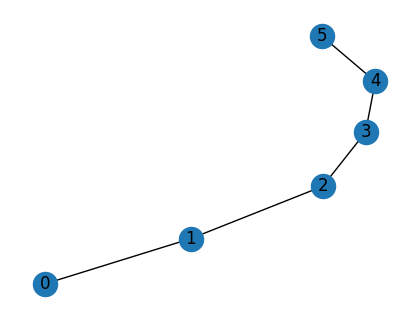

[0, 1, 2, 3] 300.0


In [51]:
# network graph
N = 6# number of nodes
node_list = np.arange(N)
G = nx.Graph()
G.add_nodes_from(node_list)
p = 100
q = 0.5
# adj_mat = np.diag(np.ones(N-1),1)
adj_mat = np.zeros((N,N))
for n in range(N-1):
    adj_mat[n,n+1] = p
# adj_mat[1,2] = 200
# adj_mat[0,4] = p
# adj_mat[3,4] = p
# adj_mat[1,2] = p
adj_mat += adj_mat.T
G = nx.from_numpy_array(adj_mat)
# G.add_edges_from([(q,q+1) for q in range(N-1)])
plt.figure(figsize=(4,3))
nx.draw(G,  with_labels=True)
plt.show()

p0to3 = nx.shortest_path(G, source=0, target=3, weight="weight")
length = nx.shortest_path_length(G, source=0, target=3, weight="weight")

print(p0to3,length)

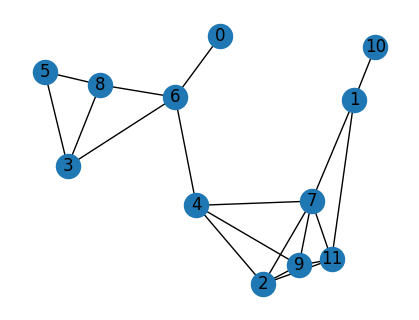

In [5]:
# random network graph
N = 12# number of nodes
node_list = np.arange(N)

# p = 0.5
length = 1
width = 0.5
np.random.seed = 3
pos = dict()
for node in range(N):
    pos[node] = (np.random.rand()*length,np.random.rand()*width)
    
# adj_mat = np.zeros((N,N))
# for i in range(N):
#     adj_mat[i,i+1:] = np.random.rand(N-i-1)< p*np.exp(-())
    
# adj_mat += adj_mat.T
# G= nx.from_numpy_array(adj_mat)

# G = nx.waxman_graph(N, beta=0.4, alpha=0.1, L=1, domain=(0, 0, 1, 1))#, metric=None, seed=None
# dist = lambda x, y: sum(abs(a - b) for a, b in zip(x, y))
# G = nx.waxman_graph(N, 1, 0.15, L = .5)#, metric=dist)
G = nx.random_geometric_graph(N, 0.3, dim=2, pos=pos, p=2)

pos = nx.get_node_attributes(G, 'pos')
weights = dict()
for e in G.edges():
    weights[e] = np.linalg.norm([pos[e[0]][0]-pos[e[1]][0],pos[e[0]][1]-pos[e[1]][1]])
nx.set_edge_attributes(G, values = weights, name = 'weight')

plt.figure(figsize=(4,3))
nx.draw(G,pos,with_labels=True)
plt.show()

# for node in G.nodes():
#     print(node)
# print(G.pos())

# p0to3 = nx.shortest_path(G, source=0, target=3, weight="weight")
# length = nx.shortest_path_length(G, source=0, target=3, weight="weight")

# print(p0to3,length)

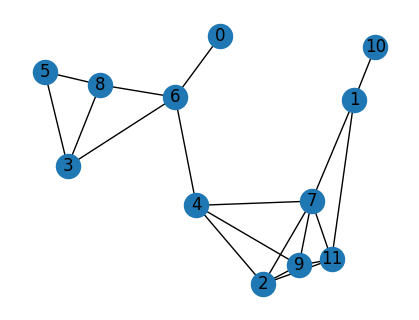

In [6]:
plt.figure(figsize=(4,3))
nx.draw(G,pos, with_labels=True)
plt.show()
# # pos = nx.get_node_attributes(G, 'pos')
# # # print(pos)
# # # weights = nx.get_edge_attributes(G, 'weight')
# # # print(weights)
# # weights = dict()
# # for e in G.edges():
# # #     G[e[0]][e[1]] = np.linalg.norm([pos[e[0]][0]-pos[e[1]][0],pos[e[0]][1]-pos[e[1]][1]])
# #     weights[e] = np.linalg.norm([pos[e[0]][0]-pos[e[1]][0],pos[e[0]][1]-pos[e[1]][1]])
# # nx.set_edge_attributes(G, values = weights, name = 'weight')
# # w_out = nx.get_edge_attributes(G, 'weight')
# # print(w_out)
# print(weights)
# print(nx.shortest_path(G, source=7, target=1, weight="weight"))
# print(nx.shortest_path_length(G, source=7, target=1, weight="weight"))

In [377]:
Nmax = 10
Lmax = 0.3
D0 = 1
D = D0*np.ones(N)
s_list = [9]#,0,6]# source
t_list = [10]#,11,8] # destination

C = len(s_list)

# indices: (superscript, subscript)
m = Model()
# x_size = R**2 + R + 1
# y_size = R**2 + R + 1
x = m.addMVar((C,N,N), vtype=GRB.BINARY,name="x")
yu = m.addMVar((N), vtype=GRB.BINARY,name="yu")

R_list = list(set(node_list)-set(np.concatenate((s_list,t_list))))

for user_pair in range(C):
    s = s_list[user_pair]
    t = t_list[user_pair]
    
#     R_list = list(set(node_list)-{s,t})
#     R = len(R_list)
#     y_sum = 0
    number = 0
    path_s = x[user_pair][s][t]
    path_t = x[user_pair][s][t]
    for n1 in R_list:
        m.addConstr( nx.shortest_path_length(G, source=s, target=n1, weight="weight")*x[user_pair][s][n1] <= Lmax ) 
        m.addConstr( nx.shortest_path_length(G, source=n1, target=t, weight="weight")*x[user_pair][n1][t] <= Lmax ) 
#         y_sum += yu[n1]
#         y_const = x[user_pair][n1][t]
        path = x[user_pair][n1][t] - x[user_pair][s][n1]
        number += x[user_pair][s][n1]+ x[user_pair][n1][t]
        path_s += x[user_pair][s][n1]
        path_t += x[user_pair][n1][t]
        for n2 in R_list:
            if n2 != n1:
                m.addConstr( nx.shortest_path_length(G, source=n1, target=n2, weight="weight")*x[user_pair][n1][n2] <= Lmax ) 
                path += x[user_pair][n1][n2] - x[user_pair][n2][n1]
                number += x[user_pair][n1][n2]
#                 y_const += x[user_pair][n1][n2]

#         m.addConstr( y_const <= D[n1]*yu[n1] ) 
        m.addConstr( path == 0 ) 
    m.addConstr( number <= Nmax + 1 ) 
    m.addConstr( path_s == 1 )
    m.addConstr( path_t == 1 )
    m.addConstr( nx.shortest_path_length(G, source=s, target=t, weight="weight")*x[user_pair][s][t] <= Lmax ) 

# R_list = list(set(node_list)-set(np.concatenate((s_list,t_list))))

# y_const = np.zeros(len(R_list))
    
for n1 in R_list:
    y_const = 0
    for user_pair in range(C):
        s = s_list[user_pair]
        t = t_list[user_pair]
        y_const += x[user_pair][n1][t]
        for n2 in R_list:
            if n2 != n1:
                y_const += x[user_pair][n1][n2]

    m.addConstr( y_const <= D[n1]*yu[n1] ) 


y_sum = 0
for n1 in range(N):
    if (n1 not in s_list) and (n1 not in t_list):
        y_sum += yu[n1]

m.setObjective(y_sum , GRB.MINIMIZE)
m.optimize()

x_opt = np.zeros((C,N,N))
y_opt = np.zeros(N)
for i in range(N):
    if m.getVars()[len(s_list)*N**2+i].X > 0:
        y_opt[i] = m.getVars()[len(s_list)*N**2+i].X
    for j in range(N):
        for user_pair in range(C):
            if m.getVars()[user_pair*N**2+i*N+j].X > 0:
                x_opt[user_pair,i,j] = m.getVars()[user_pair*N**2+i*N+j].X

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 134 rows, 156 columns and 553 nonzeros
Model fingerprint: 0xc10af06e
Variable types: 0 continuous, 156 integer (156 binary)
Coefficient statistics:
  Matrix range     [4e-02, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-01, 1e+01]
Presolve removed 127 rows and 148 columns
Presolve time: 0.00s
Presolved: 7 rows, 8 columns, 22 nonzeros
Variable types: 0 continuous, 8 integer (8 binary)
Found heuristic solution: objective 4.0000000

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 12 (of 12 available processors)

Solution count 1: 4 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.000000000000e+00, best bound 4.000000000000e+00, gap 0.0000%


(9, 10) : [array([1, 7]), array([3, 4]), array([4, 1]), array([ 7, 10]), array([9, 3])]


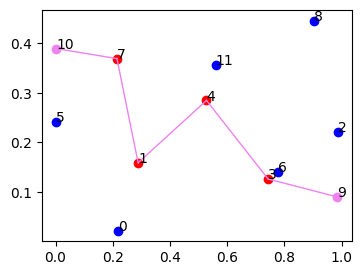

In [378]:
# Gopt = G.copy()
# Gopt = nx.Graph()
# Gopt.add_nodes_from(np.arange(N))
# Gopt= nx.from_numpy_array(x_opt)
plt.figure(figsize=(4,3))
# nx.draw(Gopt, pos, with_labels=True)
for i,y in enumerate(y_opt):
    if i not in np.concatenate((s_list,t_list)):
        if y == 1:
            plt.plot(pos[i][0],pos[i][1],"ro")#,markersize=5)
            plt.text(pos[i][0],pos[i][1],"%d" % i)
        else:
            plt.plot(pos[i][0],pos[i][1],"bo")
            plt.text(pos[i][0],pos[i][1],"%d" % i)
            
colors = ["violet","orange","gray"]
for user_pair in range(C):
    s = s_list[user_pair]
    plt.plot(pos[s][0],pos[s][1],"o", color = colors[user_pair])
    plt.text(pos[s][0],pos[s][1],"%d" % s)
    t = t_list[user_pair]
    plt.plot(pos[t][0],pos[t][1],"o", color = colors[user_pair])
    plt.text(pos[t][0],pos[t][1],"%d" % t)

    edges = np.argwhere(x_opt[user_pair,:,:]>0)
    path_output = []
    for e in edges:
        if G.has_edge(e[0],e[1]):
            plt.plot([ pos[e[0]][0],pos[e[1]][0] ], [ pos[e[0]][1],pos[e[1]][1] ], color = colors[user_pair], linewidth=1)
            path_output.append(e)
        else:
            path = nx.shortest_path(G, source=e[0], target=e[1], weight="weight")
            path_output.append(path)
            for i in range(len(path)-1):
                e1 = path[i]
                e2 = path[i+1]
                plt.plot([ pos[e1][0],pos[e2][0] ], [ pos[e1][1],pos[e2][1] ], color = colors[user_pair], linewidth=1)
                
    print((s_list[user_pair],t_list[user_pair]),":",path_output)
plt.show()


## multiplexing

In [ ]:
def ent_rate_memory_exact(p_list,W):
    N = len(p_list) # number of links (or number of repeaters -1)
    Q = np.zeros((W,N)) 
    for k, p_k in enumerate(p_list):
        for i in range(W):
            Q[i,k] = comb(W,i+1)* p_k**(i+1) * (1-p_k)**(W-i-1)

    P = np.zeros((W,N)) 
    P[:,0] = Q[:,0]     
    for k in range(1,N):
        for i in range(W):
            P[i,k] = P[i,k-1]* np.sum(Q[i:,k]) + Q[i,k]* np.sum(P[i+1:,k-1])

    return np.sum(np.arange(1,W+1)*P[:,N-1])



In [9]:
Nmax = 10
Lmax = 0.3

W = 3
D0 = 10
D = D0*np.ones(N)
s_list = [5,3]# source
t_list = [11,10] # destination

C = len(s_list)

# indices: (superscript, subscript)
m = Model()
x = m.addMVar((C,W,N,N), vtype=GRB.BINARY,name="x")
yu = m.addMVar((N), vtype=GRB.BINARY,name="yu")

R_list = list(set(node_list)-set(np.concatenate((s_list,t_list))))

for user_pair in range(C):
    s = s_list[user_pair]
    t = t_list[user_pair]
    for memory in range(W):
        
        number = 0
#         path_s = x[user_pair][memory][s][t]
#         path_t = x[user_pair][memory][s][t]
        for n1 in R_list:
            m.addConstr( nx.shortest_path_length(G, source=s, target=n1, weight="weight")*x[user_pair][memory][s][n1] <= Lmax ) 
            m.addConstr( nx.shortest_path_length(G, source=n1, target=t, weight="weight")*x[user_pair][memory][n1][t] <= Lmax ) 
            path = x[user_pair][memory][n1][t] - x[user_pair][memory][s][n1]
            number += x[user_pair][memory][s][n1]+ x[user_pair][memory][n1][t]
#             path_s += x[user_pair][memory][s][n1]
#             path_t += x[user_pair][memory][n1][t]
            for n2 in R_list:
                if n2 != n1:
                    m.addConstr( nx.shortest_path_length(G, source=n1, target=n2, weight="weight")*x[user_pair][memory][n1][n2] <= Lmax ) 
                    path += x[user_pair][memory][n1][n2] - x[user_pair][memory][n2][n1]
                    number += x[user_pair][memory][n1][n2]

            m.addConstr( path == 0 ) 
        m.addConstr( number <= Nmax + 1 ) 
#         m.addConstr( path_s == 1 )
#         m.addConstr( path_t == 1 )
        m.addConstr( nx.shortest_path_length(G, source=s, target=t, weight="weight")*x[user_pair][memory][s][t] <= Lmax ) 

for user_pair in range(C):
    s = s_list[user_pair]
    t = t_list[user_pair]
    path_s = 0
    path_t = 0
    for memory in range(W):        
        path_s += x[user_pair][memory][s][t]
        path_t += x[user_pair][memory][s][t]
        for n1 in R_list:
            path_s += x[user_pair][memory][s][n1]
            path_t += x[user_pair][memory][n1][t]

    m.addConstr( path_s == 1 )
    m.addConstr( path_t == 1 )
   
for n1 in R_list:
    y1_const = 0
    y2_const = 0
    for user_pair in range(C):
        s = s_list[user_pair]
        t = t_list[user_pair]
        for memory in range(W):
            y1_const += (1+memory)*x[user_pair][memory][n1][t]
            y2_const += (1+memory)*x[user_pair][memory][s][n1]
            for n2 in R_list:
                if n2 != n1:
                    y1_const += (1+memory)*x[user_pair][memory][n1][n2]
                    y2_const += (1+memory)*x[user_pair][memory][n2][n1]
    m.addConstr( y1_const <= D[n1]*yu[n1] ) 
    m.addConstr( y2_const <= D[n1]*yu[n1] ) 


for n1 in range(N):
    for n2 in range(N):
        if n2 != n1:
            for user_pair in range(C):
                x_const = 0
                for memory in range(W):
                    x_const += x[user_pair][memory][n1][n2]

                m.addConstr( x_const <= 1 ) 

y_sum = 0
for n1 in range(N):
    if (n1 not in s_list) and (n1 not in t_list):
        y_sum += yu[n1]

m.setObjective(y_sum , GRB.MINIMIZE)
m.optimize()

x_opt = np.zeros((C,W,N,N))
y_opt = np.zeros(N)
for i in range(N):
    if m.getVars()[len(s_list)*W*N**2+i].X > 0:
        y_opt[i] = m.getVars()[len(s_list)*W*N**2+i].X
    for j in range(N):
        for user_pair in range(C):
            for memory in range(W):
                if m.getVars()[(user_pair*W+memory)*N**2+i*N+j].X > 0:
                    x_opt[user_pair,memory,i,j] = m.getVars()[(user_pair*W+memory)*N**2+i*N+j].X
                    
                    

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 776 rows, 876 columns and 3322 nonzeros
Model fingerprint: 0x7f844470
Variable types: 0 continuous, 876 integer (876 binary)
Coefficient statistics:
  Matrix range     [8e-02, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-01, 1e+01]
Presolve removed 711 rows and 787 columns
Presolve time: 0.00s
Presolved: 65 rows, 89 columns, 498 nonzeros
Variable types: 0 continuous, 89 integer (89 binary)
Found heuristic solution: objective 7.0000000
Found heuristic solution: objective 6.0000000

Root relaxation: objective 5.000000e+00, 10 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0

(5, 11) : []
(5, 11) : [array([4, 7]), array([5, 8]), array([6, 4]), array([ 7, 11]), array([8, 6])]
(5, 11) : []
(3, 10) : []
(3, 10) : []
(3, 10) : [array([ 1, 10]), array([3, 6]), array([4, 7]), array([6, 4]), array([7, 1])]


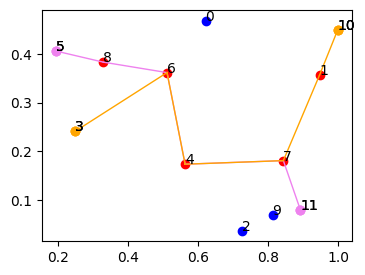

In [10]:
# Gopt = G.copy()
# Gopt = nx.Graph()
# Gopt.add_nodes_from(np.arange(N))
# Gopt= nx.from_numpy_array(x_opt)
plt.figure(figsize=(4,3))
# nx.draw(Gopt, pos, with_labels=True)
for i,y in enumerate(y_opt):
    if i not in np.concatenate((s_list,t_list)):
        if y == 1:
            plt.plot(pos[i][0],pos[i][1],"ro")#,markersize=5)
            plt.text(pos[i][0],pos[i][1],"%d" % i)
        else:
            plt.plot(pos[i][0],pos[i][1],"bo")
            plt.text(pos[i][0],pos[i][1],"%d" % i)
            
colors = ["violet","orange","gray"]
for user_pair in range(C):
    for memory in range(W):
        s = s_list[user_pair]
        plt.plot(pos[s][0],pos[s][1],"o", color = colors[user_pair])
        plt.text(pos[s][0],pos[s][1],"%d" % s)
        t = t_list[user_pair]
        plt.plot(pos[t][0],pos[t][1],"o", color = colors[user_pair])
        plt.text(pos[t][0],pos[t][1],"%d" % t)

        edges = np.argwhere(x_opt[user_pair,memory,:,:]>0)
        path_output = []
        for e in edges:
            if G.has_edge(e[0],e[1]):
                plt.plot([ pos[e[0]][0],pos[e[1]][0] ], [ pos[e[0]][1],pos[e[1]][1] ], color = colors[user_pair], linewidth=1)
                path_output.append(e)
            else:
                path = nx.shortest_path(G, source=e[0], target=e[1], weight="weight")
                path_output.append(path)
                for i in range(len(path)-1):
                    e1 = path[i]
                    e2 = path[i+1]
                    plt.plot([ pos[e1][0],pos[e2][0] ], [ pos[e1][1],pos[e2][1] ], color = colors[user_pair], linewidth=1)

        print((s_list[user_pair],t_list[user_pair]),":",path_output)
plt.show()


In [429]:
m.getVars()[(W+1)*N**2+2]

<gurobi.Var x[1,1,0,2] (value 0.0)>